In [1]:
import numpy as np
%matplotlib widget
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import itertools
from functools import reduce
from scipy.stats import entropy
from itertools import product
from copy import deepcopy

## Setting up Cat Country

In [5]:
def initialize_cat_grid_neighbors (L):
    # create a numpy ndarray to represent the regular lattice
    # allows for efficient operations over the lattice space
    N = L**2
    lattice_shape = (L,L)
    lattice_array = np.arange(N).reshape(lattice_shape)
    
    # function to get the index (location) of a desired cat in the lattice
    loc = lambda s : list(zip(*np.where(lattice_array == s)))[0]
    
    all_cat_locs = [loc(i) for i in range(N)]
    
    offsets = []
    for dim in range(2):
        offsetplus = np.zeros(2)
        offsetplus[dim] = 1
        offsets.append(offsetplus)
        offsetminus = np.zeros(2)
        offsetminus[dim] = -1
        offsets.append(offsetminus)
    offsets = np.array(offsets, dtype=int)
    
    def get_neighbors(cat):

        this_cat_loc = loc(cat)

        '''
        The boundary conditions wrap around,
        making the 2D lattice connected according to a toroidal / donut shape.
        This is so that each cat on a corner or edge also has a full set of 4 neighbors.
        '''
        def correct_edges (row):
            out = deepcopy(row)
            for idx in range(len(lattice_shape)):
                if row[idx] == lattice_shape[idx] and this_cat_loc[idx] == lattice_shape[idx] - 1:
                    out[idx] = 0

            return out
        
        neighbors = this_cat_loc + offsets
        neighbors = np.apply_along_axis(correct_edges, 1, neighbors)
        return set([lattice_array.item(tuple(n)) for n in neighbors])
    
    all_neighbors = {i: get_neighbors(i) for i in range(N)}

    return N, lattice_array, all_neighbors

'''
Call the function above to initialize the grid of cats (each cat has a specific number assigned to it), 
and to create a dictionary that maps every cat to its set of neighbors.

You can change the number of cats in the cat country by changing L. 
Since the cats live on a 2D grid, the number of cats N = L*L
'''

L = 10
num_cats, cats, cat_neighbors = initialize_cat_grid_neighbors (L)
# function to get the index (location) of a desired cat in the lattice
loc = lambda s : list(zip(*np.where(cats == s)))[0]


'''
Display the resulting 2D grid of cats, numbered
'''

# print(cats)
# print()

'''
Display the each neighbor of a specific cat with "O".
'''


def print_colored_neighbors(i):
    for row in cats:
        print(' '.join('\033[93m' + 'O' if element in cat_neighbors[i]
                   else '\033[92m' + '-'
                   for element in row))

'''
To change the cat in question, change the argument of the following function.
'''
print_colored_neighbors(25)

- - - - - - - - - -
- - - - - O - - - -
- - - - O - O - - -
- - - - - O - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -


## Functions for Simulation

In [3]:
'''
Functions that initialize the cat opinions and carry forward the MCMC simulation
'''

def initialize_cat_opinions ():
    '''
    This function randomly fills in each cat's opinion with 50% probability for and 50% probability against.
    '''
    return np.random.choice([-1, 1], num_cats, p=[0.5, 0.5]).reshape((L, L))

def average_opinion (opinions):
    # maybe change this to return pass to make students do it :)
    return np.sum(opinions)/num_cats

def friction (cat, opinions):
    '''
    This function returns the amount of friction that an individual cat has with its neighbors
    '''
    this_opinion = opinions[loc(cat)]
    neighbor_opinions = [opinions[loc(n)] for n in cat_neighbors[cat]]
    friction = np.sum(-1*this_opinion*neighbor_opinions)
    # maybe change this to friction = pass to make students do it :)
    return friction

def delta_friction_if_flipped (cat, opinions):
    '''
    This function returns how the friction that an individual cat has with its neighbors 
    would change if that cat flipped its opinion
    '''
    this_opinion = opinions[loc(cat)]
    neighbor_opinions = [opinions[loc(n)] for n in cat_neighbors[cat]]
    delta_friction = np.sum(-1*this_opinion*neighbor_opinions) - np.sum(this_opinion*neighbor_opinions)
    # maybe change this to delta_friction = pass to make students do it :)
    return delta_friction

def MCMC_cats_one_step(I, opinions):
    '''
    This function changes the state of a randomly chosen cat according to the MCMC algorithm
    '''
    candidate_cat = np.random.choice(num_cats)
    df = delta_friction_if_flipped (candidate_cat, opinions)
    prob_flip = np.min([np.exp(df / I), 1])
    # maybe change this to prob_flip = pass to make students do it :)
    a = np.random.rand()
    if a < prob_flip:
        opinions[loc(candidate_cat)] = -1*opinions[loc(candidate_cat)]
    return opinions

def MCMC_cats(I, opinions, num_steps):
    
    for step in range(num_steps):
        opinions = MCMC_cats_one_step(I, opinions)
        
    return opinions

## Running the Simulations & Plotting the Results

C:\Users\farit\AppData\Local\Temp\ipykernel_17824\956150026.py:39: RuntimeWarning: overflow encountered in exp
  prob_flip = np.min([np.exp(df / I), 1])


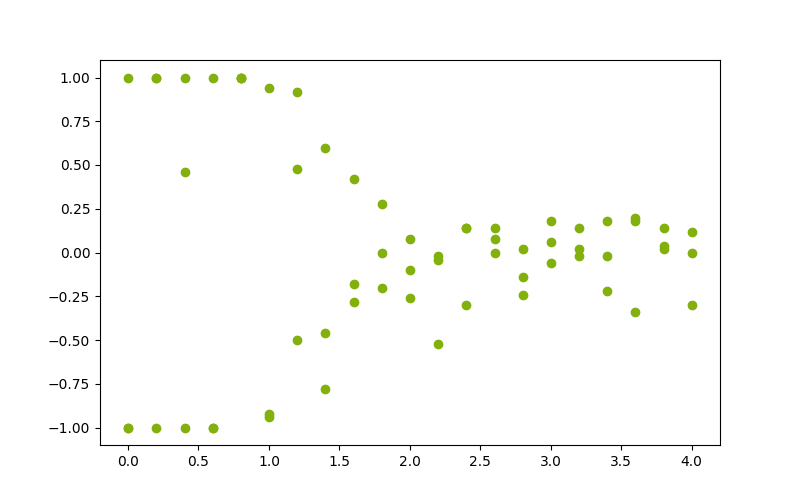

In [4]:
'''
Each experiment runs the simulation once, giving one value of (indecisiveness = I, steady-state average opinion)
Note that if the number of steps in the simulation is not large enough, the country will not reach steady state.

Note also that running this cell may take a while, 
depending on how large your cat country is, 
how many steps you are running each simulation, 
how many values of I you are testing, 
and how powerful your computer is.
'''

def one_experiment (I, num_steps):
    '''
    Initialize the cats' opinions
    '''
    cat_opinions = initialize_cat_opinions()
    
    '''
    Run the Markov Chain Monte Carlo simulation to obtain cat country's steady state opinion for a given I
    '''
    final_cat_opinions = MCMC_cats(I, cat_opinions, num_steps)
    
    '''
    Calculate and return the final average opinion
    '''
    avg = average_opinion(final_cat_opinions)
    return avg

'''
Change the values of I for which you want to run simulations
'''
all_I_values_to_test = np.linspace(0.001, 4.001, 21)


def all_experiments (num_experiments_per_I, num_steps):
    results = []
    for I in all_I_values_to_test:
        for i in range(num_experiments_per_I):
            results.append(np.array([I, one_experiment (I, num_steps)]))
    return results

'''
Set the parameters of the experiments and run them to get the results
'''
num_experiments_per_I = 3
num_steps = 20000
results = all_experiments (num_experiments_per_I, num_steps)

'''
Plot the results
'''

results = np.array(results)
fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(results[:,0], results[:,1], c='#82b00c')  

### You can clearly see the sharp phase transition that occurs below a certain value of the average cat indecisiveness!